In [1]:
import numpy as np
import pandas as pd
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from matplotlib import pyplot as plt
import cv2

2023-10-02 02:38:08.110673: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-02 02:38:08.110735: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-02 02:38:08.110767: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-02 02:38:08.119955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 02:38:09.134607: W tensorflow/compiler/

In [2]:
# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]
    
    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    
    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    
    # Take the index finger tip
    landmark = hand_landmarks[8]

    # Add text label to the landmark
    cv2.putText(annotated_image, "({:.2f}, {:.2f}, {:.2f})".format(landmark.x, landmark.y, landmark.z), (int((landmark.x) * width), int((landmark.y)*height) - MARGIN), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

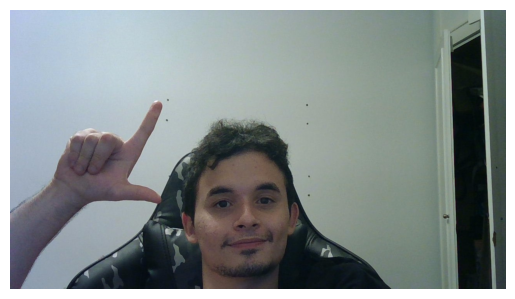

In [4]:
image = mp.Image.create_from_file("images/image.jpg").numpy_view()

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()

### Landmark Map
<p>For every Hand Landmark the GHUM model, the algorithm will return the <it>(x, y, z)</it></p>

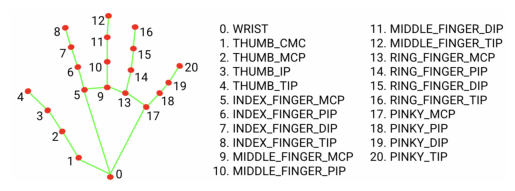

In [5]:
image = mp.Image.create_from_file("images/hand_landmarks.png").numpy_view()

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()

(-0.5, 1279.5, 719.5, -0.5)

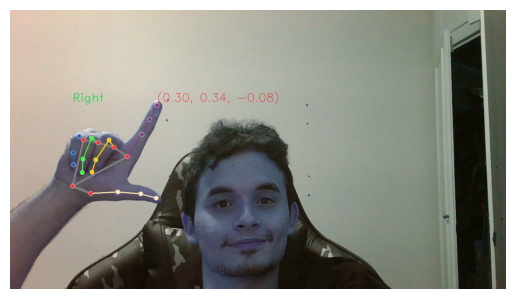

In [6]:
# STEP 3: Load the input image.
image = mp.Image.create_from_file("images/image.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

test_sample = detection_result.hand_landmarks[0]
# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
plt.axis('off')  # Optional: Turn off axis labels and ticks

In [7]:
from models import AlphabetModel
import torch
from sklearn.model_selection import train_test_split

asl = AlphabetModel()

In [8]:
df = pd.read_csv("data/asl_dataset.csv", index_col=0)
X_train = df.drop("class", axis=1)
y_train = df["class"]

df2 = pd.read_csv("data/my_dataset.csv", index_col=0)
X_test = df2
y_test = pd.Series(["L"])

asl.set_nn(X_train, y_train)

In [9]:
asl.nn.load_state_dict(torch.load("pre_trained_asl.pth"))

<All keys matched successfully>

(-0.5, 1279.5, 719.5, -0.5)

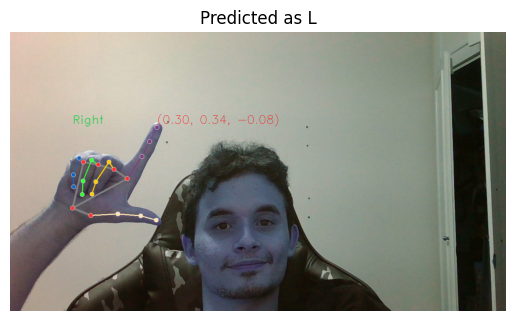

In [10]:
import string

pred = asl.predict(X_test, y_test)

image = mp.Image.create_from_file("images/image.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

test_sample = detection_result.hand_landmarks[0]
# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
plt.title(f"Predicted as {string.ascii_uppercase[pred[0][0]]}")
plt.axis('off')  # Optional: Turn off axis labels and ticks